# Trabajo Práctico 1: Propiedades en Venta - Random Forest

## Grupo 11 - "Los Outliers"

- Castillo, Carlos
- Destefanis, Juan Pablo
- Gómez, Celeste

## Libraries

In [ ]:
!pip install -U scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.tree import export_text

from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

## Load del DataFrame a utilizar

Cargo los datos con los avisos clasificados con su tipo de precio.

In [ ]:
df = pd.read_csv("https://drive.google.com/uc?id=1GhsJwy29gS2y_HibaDeChkx-ozSc2Qc3", index_col=0)

## Transformación de los datos

Lo primero que hacemos para construir un clasificador Random Forest es transformar los datos para poder usarlos sin problemas. Para ello, uso One Hot encoding sobre las columnas `neighbourhood` y `property_type`, respectivamente. Consideramos que ambos pueden ser muy útiles a la hora de clasificar las propiedades según el precio. Cuando hicimos el análsis de clusters, notamos que muchas propiedades de precios altos se concentraban en determinados barrios, con lo cual podría ser información útil a tener en cuanto durante la clasificación de los anuncios. De la misma forma, los datos de la cantidad de habitaciones y del tamaño de la superficie de las propiedades guardan una relación con el precio de las mismas.

Por otra parte, nos deshacemos de otros atributos que consideramos irrelevantes, como el ID y los títulos de los anuncios. También nos deshacemos de los datos de los precios, de las coordenadas (dado que al tener los barrios serían redundantes) y de las fechas relacionadas a las publicaciones.



In [ ]:
target = "tipo_precio"
semilla = 137

# OneHot encoding para tipo de propiedad
df_encoded = pd.get_dummies(df, columns=["property_type"], drop_first=True)

df_x = df_encoded.drop([
    'id',
    'start_date',
    'end_date',
    'tipo_precio',
    'latitud',
    'longitud',
    'property_title',
    'precio_m2',
    'property_price'], axis=1)

df_y = df_encoded[target]

Se intento usar Target Encoding para `barrio`, pero resultó complicado de lograr. La justificación de su uso era la alta cardinalidad de la columna.

In [ ]:
# Target Encoding para el barrio
# target_encoder.fit_transform(
#     df_x.loc[:, ['neighbourhood']],
#     df_y
# )

En lugar de eso, se usó One Hot Encoding, pero reduciendo la cantidad de valores a los 10 más frecuentes, y agrupando el resto en otra columna. El objetivo de esto es no agrandar por demás las dimensiones del dataframe como resultado del encoding.

In [ ]:
barrios_limite = df_x['neighbourhood'].value_counts()[10]

encoder = OneHotEncoder(
  min_frequency = barrios_limite,
  handle_unknown = 'infrequent_if_exist'
)

encoder.fit(df_x[['neighbourhood']])

barrios_encodeados = encoder.transform(df_x[['neighbourhood']])
train_df_output = pd.DataFrame(
    barrios_encodeados.toarray(),
    columns=encoder.get_feature_names_out(),
    index=df_x.index
)

df_x = pd.concat([train_df_output, df_x.drop('neighbourhood', axis=1)], axis=1)

Genero los conjuntos de `test` y de `train`.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, random_state=semilla)

## Randomized Search

Usamos Stratified KFold en lugar de solo KFold porque hay una distribución dispareja en las categorías del target. Por cómo lo armamos, hay más propiedades con la categoría `medio` que de las otras dos. Con lo cual, queremos tratar de mantener esa proporción en cada fold.

Elegimos `5` folds por la cantidad de filas del dataframe. Nos dejaría con una cantidad de filas en cada set de validación suficiente para ser representativos de todo el conjunto.

In [ ]:
X_train.shape

(66977, 18)

También elegimos `macro` como parámetro del `average` del scorer, para que tengan igual peso el score de cada label, y no tenga más peso las predicciones correctas de 'medio' por ser el que más aparece en el dataframe.

Para buscar los hiperparámetros, consideramos que la métrica más adecuada era la de F1 score, que considera tanto la precisión del modelo, como su recall.

Utilizamos RandomizedSearch en lugar de GridSearch para ahorrar tiempo mientras experimentamos.

In [ ]:
max_depth = list(range(1,6))
max_depth.append(None)

params_grid = {
    'n_estimators': list(range(20, 101)),
    'criterion': ['gini','entropy','log_loss'],
    'max_depth': max_depth,
    'min_samples_split': [0.2, 0.4, 0.6, 0.8],
    'max_features': ['sqrt', 'log2', 10, 15]
}

In [ ]:
folds=5
kfoldcv = StratifiedKFold(n_splits=folds)

base_classifier = RandomForestClassifier(n_jobs=-1, random_state=semilla)

scorer_fn = metrics.make_scorer(metrics.f1_score, labels=['bajo', 'medio', 'alto'], average='macro', pos_label=None)
randomcv = RandomizedSearchCV(estimator=base_classifier,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=30)

randomcv.fit(X_train,y_train);

In [ ]:
print("Mejores parametros: ", randomcv.best_params_)
print("Mejor F1 Score: ", randomcv.best_score_)
print("Mejor clasificador: ", randomcv.best_estimator_)

best_classifier_random_search = randomcv.best_estimator_

Mejores parametros:  {'n_estimators': 35, 'min_samples_split': 0.2, 'max_features': 15, 'max_depth': 2, 'criterion': 'entropy'}
Mejor F1 Score:  0.268255741234777
Mejor clasificador:  RandomForestClassifier(criterion='entropy', max_depth=2, max_features=15,
                       min_samples_split=0.2, n_estimators=35, n_jobs=-1,
                       random_state=137)


In [ ]:
first_tree = best_classifier_random_search.estimators_[0]
rules = export_text(first_tree, feature_names=best_classifier_random_search.feature_names_in_)
print(rules)

|--- neighbourhood_infrequent_sklearn <= 0.50
|   |--- neighbourhood_Balvanera <= 0.50
|   |   |--- class: 2.0
|   |--- neighbourhood_Balvanera >  0.50
|   |   |--- class: 1.0
|--- neighbourhood_infrequent_sklearn >  0.50
|   |--- property_surface_total <= 57.34
|   |   |--- class: 2.0
|   |--- property_surface_total >  57.34
|   |   |--- class: 1.0



Vemos que el árbol seleccionado se concentró solamente en las columnas de barrios, ignorando el resto de las columnas. Probablemente se deba a la gran cantidad de columnas que quedaron fruto del One Hot Encoding. Como nota aparte, aclaro que la columna llamada `neighbourhood_infrequent_sklearn` es la columna que agrupa los barrios menos frecuentes.

              precision    recall  f1-score   support

        alto       0.00      0.00      0.00      4251
        bajo       0.69      0.08      0.15      4215
       medio       0.50      0.98      0.66      8279

    accuracy                           0.51     16745
   macro avg       0.40      0.35      0.27     16745
weighted avg       0.42      0.51      0.36     16745

F1-Score: 0.2698654512299767
Accuracy: 0.5067781427291729
Precision: 0.3980123284123284
Recall: 0.35498297774562504


Text(50.722222222222214, 0.5, 'True')

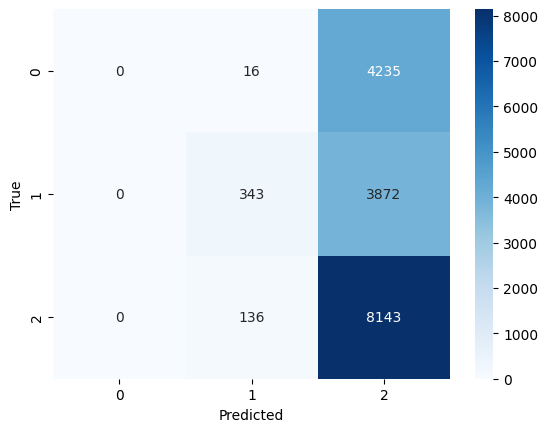

In [ ]:
y_pred= best_classifier_random_search.predict(X_test)

print(metrics.classification_report(y_test, y_pred, zero_division=0))
print('F1-Score: {}'.format(metrics.f1_score(y_test, y_pred, average='macro')))
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred, average='macro', zero_division=0)))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred, average='macro', zero_division=0)))

cm = metrics.confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Notamos en la matriz de confusión que nuestro modelo tiene una tendencia erronea a clasificar muchos avisos como de precio medio. Tampoco clasificó ninguno como un precio alto. Probablemente esto esté relacionado a la mayor presencia de esa clase en la data, a una optimización de hiperparámetros deficiente, y a una mala decisión de atributos a mantener.

El `accuracy` es del 50% porque en la gran mayoría de los casos clasifica como los anuncios como de precio `medio`. Y resulta que la mitad de los anuncios tiene esa clasificación, con lo cual los acierta, pero se equivoca en el resto.

La `precisión` es tan baja también porque son muchos los casos en los que indica que un precio es `medio`, cuando en realidad no lo es. Lo mismo pasa con el `recall`, y el F1 Score refleja los resultados de estas dos métricas.

La performance es muy similar a la de entrenamiento, con un F1 Score prácticamente igual.

## Grid Search

Queda pendiente probar con Grid Search Cross Validation.

In [ ]:
#scorer_fn = metrics.make_scorer(metrics.f1_score, labels=['bajo', 'medio', 'alto'], average='macro', pos_label=None)
#gridcv = GridSearchCV(estimator=base_classifier,
#                      param_grid = params_grid,
#                      scoring=scorer_fn,
#                      cv=kfoldcv,
#                      n_jobs=-1)

#gridcv.fit(X_train,y_train);

In [ ]:
#print(gridcv.best_params_)
#print(gridcv.best_score_)
#print(gridcv.best_estimator_)

#best_classifier_grid_search = gridcv.best_estimator_

In [ ]:
# y_pred = best_classifier_grid_search.predict(X_test)

# print(classification_report(y_test,y_pred))
# print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='macro')))

# cm = confusion_matrix(y_test,y_pred)
# sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
# plt.xlabel('Predicted')
# plt.ylabel('True')

## Visualización de uno de los árboles

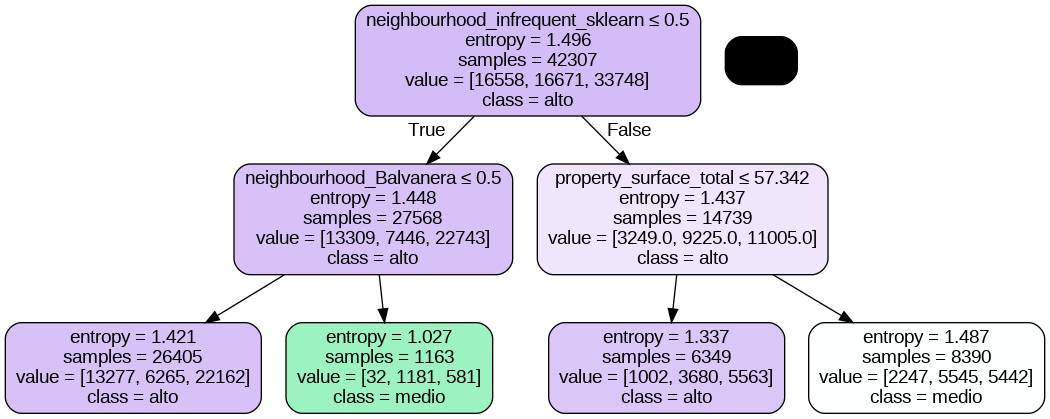

In [ ]:
dot_data = StringIO()
export_graphviz(first_tree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=best_classifier_random_search.feature_names_in_,
                class_names=['bajo','medio','alto'],
                max_depth=3)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## Exportación del modelo

In [ ]:
from joblib import dump
dump(best_classifier_random_search, 'random_forest.joblib')

['random_forest.joblib']